In [31]:
import sys, os
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Iterable, List
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

import collections
import pandas as pd 
import numpy as np
import random 
from torch.utils.data import DataLoader, random_split
import scanpy as sc

from model import Encoder, Decoder, OutputLayer

from loss_function import ZINB, maximum_mean_discrepancy

from train import train_epoch, test_epoch

from utils import plot_train

In [32]:
# Data
path_pool = [
    r"./data/mtx_0.mtx", 
    r'./data/GSE65525/GSM1599497_ES_d2_LIFminus.csv', 
    r'./data/GSE65525/GSM1599498_ES_d4_LIFminus.csv', 
    r'./data/GSE65525/GSM1599499_ES_d7_LIFminus.csv'
    ]

data_test= sc.read_csv(path_pool[2])

In [33]:
# PREVIEW
load_data = data_test.T.copy()
sc.pp.filter_genes(load_data, min_cells=50)
print('Original data size:', data_test.shape, '| Input data size:', load_data.shape)

Original data size: (24175, 683) | Input data size: (683, 7670)


In [34]:
batch_size = 50
all_data = np.array(load_data.X)

seed = 222
random.seed(seed)

m = len(all_data)
print(m)

train_data, test_data = random_split(dataset=all_data, lengths=[int(m - m * 0.2), int(m * 0.2) + 1])

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

683


In [35]:
net_struc = [all_data.shape[1], 1024, 256, 64, 32]

encoder = Encoder(features=net_struc)
decoder = Decoder(features=net_struc[1:][::-1])

# Three output layer of DCA
# dropoutRates = {'mean': 0.1, 'pi': 0.1, 'theta': 0.1}
output_layer = OutputLayer(net_struc[:2][::-1])

# Define Optimizer
lr = 5e-5

#Random seed
torch.manual_seed(seed)
param_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(param_to_optimize, lr=lr)

In [36]:
factor_zinb = 0.5
factor_mmd = 1


 EPOCH 1/50 	 train loss 0.12847050467690269 	 test loss 0.32906345729410214

 EPOCH 2/50 	 train loss 0.12820193531749013 	 test loss 0.32307683290356265

 EPOCH 3/50 	 train loss 0.12810528322017237 	 test loss 0.3176226372266338

 EPOCH 4/50 	 train loss 0.12812907093173856 	 test loss 0.3117484211051551

 EPOCH 5/50 	 train loss 0.12814431225423847 	 test loss 0.3056342201511355


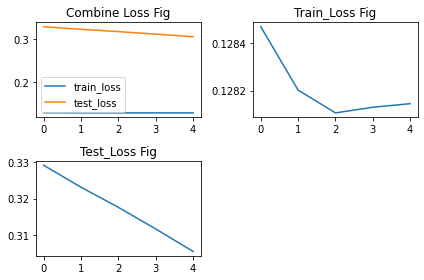


 EPOCH 6/50 	 train loss 0.12794063816140422 	 test loss 0.29834867741939797

 EPOCH 7/50 	 train loss 0.12782257555168627 	 test loss 0.29176833159732124

 EPOCH 8/50 	 train loss 0.12793483489598984 	 test loss 0.2783437575737055

 EPOCH 9/50 	 train loss 0.12778084706037474 	 test loss 0.2612733284052271

 EPOCH 10/50 	 train loss 0.12769971225724552 	 test loss 0.24708930245281135


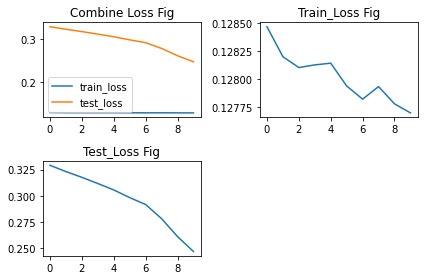


 EPOCH 11/50 	 train loss 0.12772364057464042 	 test loss 0.23437711618242474

 EPOCH 12/50 	 train loss 0.1277444004575848 	 test loss 0.2215983676214288

 EPOCH 13/50 	 train loss 0.12767831484476724 	 test loss 0.21038256596474753

 EPOCH 14/50 	 train loss 0.1277817055419251 	 test loss 0.19897791591003863

 EPOCH 15/50 	 train loss 0.12770581507420803 	 test loss 0.188880600198342


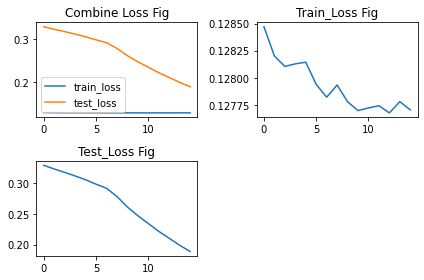


 EPOCH 16/50 	 train loss 0.12778353953099514 	 test loss 0.18059152060181555

 EPOCH 17/50 	 train loss 0.12780890010652088 	 test loss 0.17353944708831118

 EPOCH 18/50 	 train loss 0.12761844383491264 	 test loss 0.168019127671736

 EPOCH 19/50 	 train loss 0.12767594637888255 	 test loss 0.159986729169414

 EPOCH 20/50 	 train loss 0.12781538631453182 	 test loss 0.15357770014853372


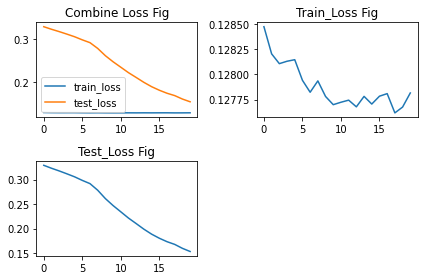


 EPOCH 21/50 	 train loss 0.12768124136732611 	 test loss 0.1495421959535919

 EPOCH 22/50 	 train loss 0.12762385584932545 	 test loss 0.14755814266900946

 EPOCH 23/50 	 train loss 0.12773991766430082 	 test loss 0.14389483946083237

 EPOCH 24/50 	 train loss 0.12759017507671874 	 test loss 0.14146491210826123

 EPOCH 25/50 	 train loss 0.12759617658761832 	 test loss 0.1404545220145344


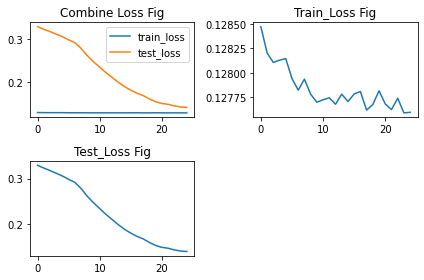


 EPOCH 26/50 	 train loss 0.12762860850100116 	 test loss 0.13909024217703048

 EPOCH 27/50 	 train loss 0.12750530766916798 	 test loss 0.1386624739988007

 EPOCH 28/50 	 train loss 0.12755045262011852 	 test loss 0.13845043808874422

 EPOCH 29/50 	 train loss 0.12763566499228005 	 test loss 0.13807866173068972

 EPOCH 30/50 	 train loss 0.1275050788571983 	 test loss 0.13783959924739642


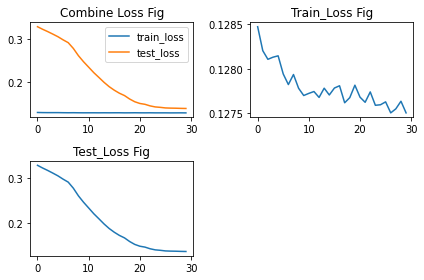


 EPOCH 31/50 	 train loss 0.127603367571429 	 test loss 0.13782300740262887

 EPOCH 32/50 	 train loss 0.12758429670508528 	 test loss 0.13792724330929945

 EPOCH 33/50 	 train loss 0.1275079355135069 	 test loss 0.1374468176904386

 EPOCH 34/50 	 train loss 0.1276319044413584 	 test loss 0.13766833117408475

 EPOCH 35/50 	 train loss 0.12766097229478995 	 test loss 0.13785803579065922


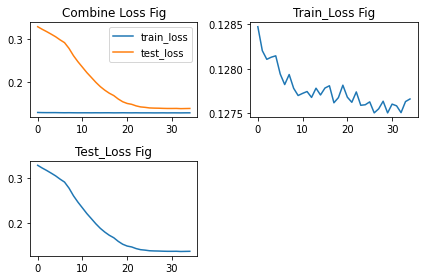


 EPOCH 36/50 	 train loss 0.12776848597404283 	 test loss 0.13848960486641765

 EPOCH 37/50 	 train loss 0.1276296006017552 	 test loss 0.1380973941218244

 EPOCH 38/50 	 train loss 0.12759166497450608 	 test loss 0.13788266773641544

 EPOCH 39/50 	 train loss 0.12757266135442824 	 test loss 0.13786927104866417

 EPOCH 40/50 	 train loss 0.12753896835522774 	 test loss 0.14212678296722636


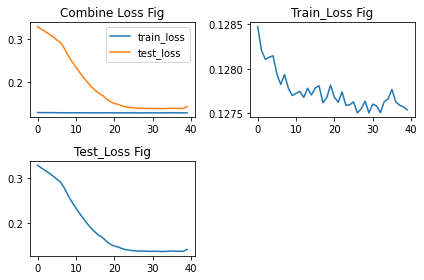


 EPOCH 41/50 	 train loss 0.12743383536845337 	 test loss 0.14351548243613138

 EPOCH 42/50 	 train loss 0.1275152059701773 	 test loss 0.14346835561042284

 EPOCH 43/50 	 train loss 0.12748559490664974 	 test loss 0.14441290737068566

 EPOCH 44/50 	 train loss 0.1275001917129908 	 test loss 0.14493955486882343

 EPOCH 45/50 	 train loss 0.12746256087725852 	 test loss 0.14403864240994418


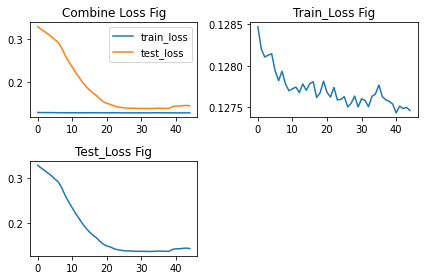


 EPOCH 46/50 	 train loss 0.12740820406120776 	 test loss 0.1430535873357397

 EPOCH 47/50 	 train loss 0.12744652919280222 	 test loss 0.14184743992603607

 EPOCH 48/50 	 train loss 0.12746965841495947 	 test loss 0.14091361874211444

 EPOCH 49/50 	 train loss 0.12742020882966318 	 test loss 0.14053066629562935

 EPOCH 50/50 	 train loss 0.1275351501646496 	 test loss 0.1410728231833799


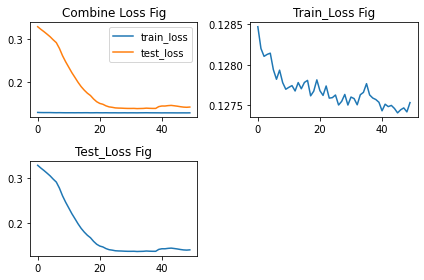

In [37]:
num_epochs = 50
all_loss = {'train_loss':[],'test_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(encoder,decoder,output_layer,train_loader,optim,factor_zinb,factor_mmd)
   test_loss = test_epoch(encoder,decoder,output_layer,test_loader,factor_zinb,factor_mmd)
   print('\n EPOCH {}/{} \t train loss {} \t test loss {}'.format(epoch + 1, num_epochs,train_loss,test_loss))
   all_loss['train_loss'].append(train_loss)
   all_loss['test_loss'].append(test_loss)
   if epoch and (epoch + 1) % 5 == 0:
      plot_train(all_loss, seperate=True)